# B2. Intial Exploratory Data Analysis

This notebook is the exploratory part of the project where I check whether the Kaggle weather dataset (ECA&D 2000–2010, 18 European stations) is actually usable for a supervised “Will it rain tomorrow in Basel?” task. Before I build any models I need to know four things: how the main variables are distributed, whether the variables relate to each other in a weather-sensible way, whether the target is reasonably balanced, and whether there are missing or bad values that would break the model. In this notebook I focus on the Basel columns only, because the rest of the project also uses Basel as the target station.

In [12]:
import os
import pandas as pd
import matplotlib.pyplot as plt


# load the same raw file as in B1
DATA_PATH = "/Users/purvigarg/Downloads/CMSE492/cmse492_project/data/raw/weather_prediction_dataset.csv"
data = pd.read_csv(DATA_PATH)

print("Loaded:", data.shape)


Loaded: (3654, 165)


### Distribution of Basel Mean Temperature 

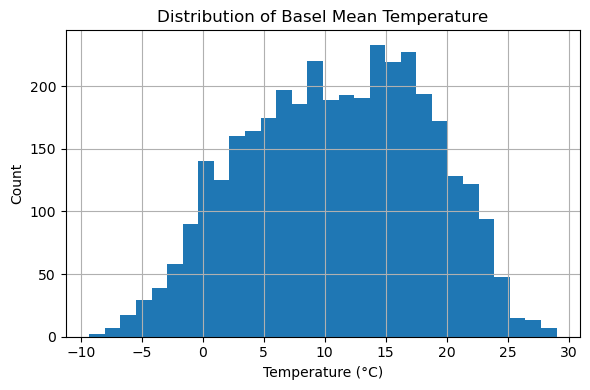

In [14]:
plt.figure(figsize=(6,4))
data["BASEL_temp_mean"].hist(bins=30)
plt.title("Distribution of Basel Mean Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/basel_temp_mean_dist.png")
plt.show()


The plot is the “Distribution of Basel Mean Temperature.” Its job is to answer: are the temperatures realistic and do we cover all seasons? The histogram showed values roughly from –10°C in winter up to the high 20s in summer, with most days between about 5°C and 18°C. That shape is exactly what I would expect for a central-European city over many years, so it tells me the data is not clipped and there are no silly constant values. 

## Basel: Humidity vs Mean Temperature

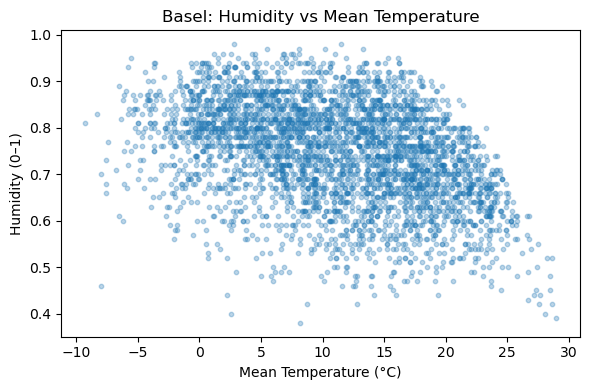

In [15]:
plt.figure(figsize=(6,4))
plt.scatter(
    data["BASEL_temp_mean"],
    data["BASEL_humidity"],
    s=10,
    alpha=0.3
)
plt.title("Basel: Humidity vs Mean Temperature")
plt.xlabel("Mean Temperature (°C)")
plt.ylabel("Humidity (0–1)")
plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/basel_temp_vs_humidity.png")
plt.show()


This figure is the scatterplot “Basel: Humidity vs Mean Temperature.” Here I wanted to see whether two weather variables behave together in a believable way. The cloud of points showed that cooler and mild days can stay fairly humid, while very warm days tend to be slightly less humid. There was no weird banding, no diagonal stripes, and no impossible values (>1 humidity), so I can say the data is continuous and realistic.

## Basel: Rain vs No Rain (today) – Class Balance

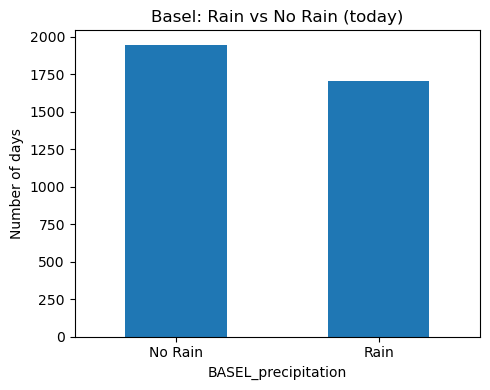

Class proportions:
BASEL_precipitation
0    0.532841
1    0.467159
Name: proportion, dtype: float64


In [16]:
rain_today = (data["BASEL_precipitation"] > 0).astype(int)
counts = rain_today.value_counts().sort_index()

plt.figure(figsize=(5,4))
counts.plot(kind="bar")
plt.xticks([0,1], ["No Rain", "Rain"], rotation=0)
plt.title("Basel: Rain vs No Rain (today)")
plt.ylabel("Number of days")
plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/basel_rain_class_balance.png")
plt.show()

print("Class proportions:")
print((counts / len(rain_today)).rename("proportion"))


This figure is the bar chart “Basel: Rain vs No Rain (today).” I built a simple binary target from today’s precipitation (BASEL_precipitation > 0) and counted how many days were rainy versus dry. The bars came out around 53% No Rain and 47% Rain. That’s important because it tells me the classification problem is not severely imbalanced, so I don’t have to start with heavy oversampling or weird loss functions.

## Basel: Fraction of Rainy Days by Month

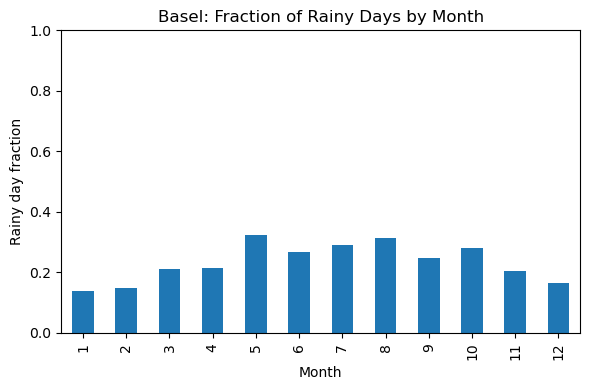

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import os

os.makedirs("figures", exist_ok=True)

# make sure DATE is datetime
data["DATE"] = pd.to_datetime(data["DATE"].astype(str), errors="coerce")

# make a rain-today flag (0/1)
rain_today = (data["BASEL_precipitation"] > 0).astype(int)

# extract month
data["MONTH"] = data["DATE"].dt.month

# group by month: average of rain_today = fraction of rainy days in that month
monthly_rain_rate = data.groupby("MONTH")[rain_today.name].mean()

plt.figure(figsize=(6,4))
monthly_rain_rate.plot(kind="bar")
plt.title("Basel: Fraction of Rainy Days by Month")
plt.xlabel("Month")
plt.ylabel("Rainy day fraction")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/basel_rain_by_month.png")
plt.show()


This figure is the monthly bar chart “Basel: Fraction of Rainy Days by Month.” I grouped by month and took the average of the rain flag, so each bar shows the typical share of rainy days in that month. This plot showed a clear seasonal pattern: some months (late spring, summer) have more rain, some winter months have less. That tells me seasonality is present in the raw data, so adding month or day-of-year features later is justified. It also tells me that a single global model will be asked to handle different regimes, which I can mention in the discussion.

## Basel: Weather Drivers vs Precipitation

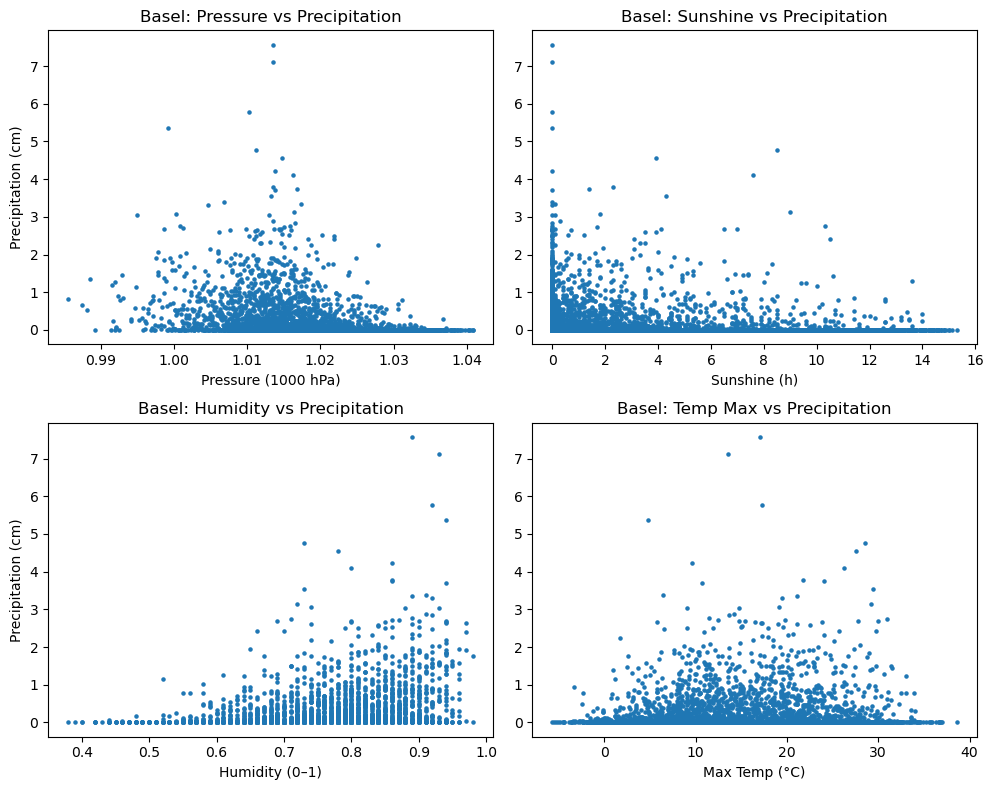

In [18]:
import matplotlib.pyplot as plt

city = "BASEL"
pref = f"{city}_"

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

# 1. Pressure vs precipitation
axes[0].scatter(data[f"{pref}pressure"], data[f"{pref}precipitation"], s=5)
axes[0].set_title("Basel: Pressure vs Precipitation")
axes[0].set_xlabel("Pressure (1000 hPa)")
axes[0].set_ylabel("Precipitation (cm)")

# 2. Sunshine vs precipitation
axes[1].scatter(data[f"{pref}sunshine"], data[f"{pref}precipitation"], s=5)
axes[1].set_title("Basel: Sunshine vs Precipitation")
axes[1].set_xlabel("Sunshine (h)")

# 3. Humidity vs precipitation
axes[2].scatter(data[f"{pref}humidity"], data[f"{pref}precipitation"], s=5)
axes[2].set_title("Basel: Humidity vs Precipitation")
axes[2].set_xlabel("Humidity (0–1)")
axes[2].set_ylabel("Precipitation (cm)")

# 4. Temp max vs precipitation
axes[3].scatter(data[f"{pref}temp_max"], data[f"{pref}precipitation"], s=5)
axes[3].set_title("Basel: Temp Max vs Precipitation")
axes[3].set_xlabel("Max Temp (°C)")

plt.tight_layout()
plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/basel_drivers_vs_precip.png", dpi=150)
plt.show()


The multi-plot figure with “Basel: Pressure vs Precipitation,” “Sunshine vs Precipitation,” “Humidity vs Precipitation,” and “Temp Max vs Precipitation” is there to check, in one shot, whether the weather variables we plan to use as features actually have signal about rain. In the pressure panel you can clearly see that when pressure is low (around 1.00–1.01) there are more and taller rain points, but when pressure gets higher (1.03–1.04) rain almost disappears — that’s exactly what we expect from basic meteorology, so it tells me pressure is a good predictor. In the sunshine panel most of the rain sits where sunshine is close to zero, so low sun = more likely rain, which means sunshine (or radiation) should enter the model with a negative effect. The humidity panel shows that wetter days can produce larger precipitation values, so humidity is also useful. Temperature max has a weaker pattern, but it still gives some context. Together, this figure basically says: “yes, the small, physics-guided feature set we used later (pressure, sunshine/radiation, humidity, temperature) is justified,” so it forms a nice bridge from EDA to modeling.

## Data Missing and Handling 

In [19]:
missing = data.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) == 0:
    print("No missing values found in this dataset (after filtering > 0).")
else:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,4))
    missing.head(20).plot(kind="bar")
    plt.title("Top columns with missing values")
    plt.ylabel("Number of missing cells")
    plt.tight_layout()
    plt.savefig("/Users/purvigarg/Downloads/CMSE492/cmse492_project/figures/missing_values_top20.png")
    plt.show()


No missing values found in this dataset (after filtering > 0).


I checked for missing values and found that this version of the dataset has no columns with missing entries above 0, so no imputation is needed at this stage.

Overall, this EDA notebook shows that the Basel subset is clean, seasonal, and well balanced for a binary rain task. The variables have sensible ranges, their relationships look like real weather, the target is not heavily skewed, and there are no obvious missing-data problems. Because of that I can safely move on to the modeling notebook, where I will create the “RainTomorrow” label by shifting precipitation by one day, engineer a few weather-based features, and compare my ML models to simple baselines.